In [326]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss
from kl.utils import load_fx
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Define the quantum circuit for 8 qubits (one per feature)
def quantum_circuit(params, x):
    n_qubits = len(x)  # Ensure we are only working with 8 qubits
    for i in range(n_qubits):
        qml.RX(x[i], wires=i)  # Apply RX to qubit i with the i-th feature
        qml.RY(params[0], wires=i)
        qml.RZ(params[1], wires=i)
    
    # Measure the expectation value of Pauli-Z on all qubits
    # Return only a single vector of length 8 (one value per qubit)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the quantum encoder
class QuantumEncoder(nn.Module):
    def __init__(self, n_qubits, n_features):
        super(QuantumEncoder, self).__init__()
        self.n_qubits = n_qubits
        self.n_features = n_features
        
        # Initialize the device with exactly 8 qubits
        self.dev = qml.device("default.qubit", wires=n_qubits)
        self.qcircuit = qml.QNode(quantum_circuit, self.dev)

    def forward(self, x):
        outputs = []
        params = torch.randn(2)  # Parameters for the quantum circuit
        
        # Loop through each sample in the batch
        for sample in x:
            sample = sample.detach().cpu().numpy()  # Convert sample to NumPy array for PennyLane
            sample = sample[:self.n_qubits]  # Ensure we're only passing 8 features for 8 qubits
            output = self.qcircuit(params, sample)  # Process the whole sample at once
            
            # Ensure that the output is a vector of length 8
            if np.shape(output) == (8, 8):
                output = np.mean(output, axis=1)  # Take the mean if it's a matrix, to reduce to (8,)
            
            # Debugging: print output shape for each sample
            # print(f"Output shape for sample after correction: {np.shape(output)}")
            
            # Ensure output is a NumPy array of consistent shape
            outputs.append(np.array(output))  # Each output is a vector of qubit expectation values (length 8)
        
        # Use np.stack() to ensure the outputs have consistent shape
        outputs_np = np.stack(outputs, axis=0)
        
        # Convert outputs to a tensor
        outputs_tensor = torch.tensor(outputs_np, dtype=torch.float32)
        return outputs_tensor  # Shape: [batch_size, 8]
    
# Define the classical decoder
class ClassicalDecoder(nn.Module):
    def __init__(self, n_features):
        super(ClassicalDecoder, self).__init__()
        self.fc1 = nn.Linear(8, 128)  # Change input size from 1 to 8 to match latent vector size
        self.fc2 = nn.Linear(128, n_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Decode the quantum output
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


# Define the quantum VAE
class QuantumVAE(nn.Module):
    def __init__(self, n_qubits, n_features):
        super(QuantumVAE, self).__init__()
        self.encoder = QuantumEncoder(n_qubits, n_features)
        self.decoder = ClassicalDecoder(n_features)

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed_x = self.decoder(latent)
        return latent, reconstructed_x


In [327]:
def train_vae_with_svm(vae, dataloader, svm, optimizer, n_epochs=10):
    vae.train()
    svm_loss_weight = 0.1  # Hyperparameter to weight the SVM loss

    for epoch in range(n_epochs):
        total_loss = 0
        for batch in dataloader:
            # Unpack the batch data (features and labels)
            x, labels = batch  # Assuming DataLoader returns (X, y)
            # Convert 0/1 labels to -1/1 for hinge loss
            labels = labels * 2 - 1  # 0 -> -1, 1 -> 1
            
            # 1. Forward pass through VAE
            latent_vectors, reconstructed_x = vae(x)  # Get the latent space representation
            
            # 2. Train the SVM on the latent space
            # Fit the SVM on the latent vectors
            svm.fit(latent_vectors.detach().cpu().numpy(), labels.cpu().numpy())
            svm_score = svm.score(latent_vectors.detach().cpu().numpy(), labels.cpu().numpy())
            
            # 3. Calculate reconstruction loss
            recon_loss = nn.MSELoss()(reconstructed_x, x)
            
            # 4. (Optional) Calculate KL divergence (if applicable)
            # Calculate KL divergence (assuming Gaussian latent space)
            mu = torch.mean(latent_vectors, dim=0)
            log_var = torch.var(latent_vectors, dim=0).log()
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # 5. Calculate the SVM hinge loss
            svm_predictions = svm.predict(latent_vectors.detach().cpu().numpy())
            svm_loss = hinge_loss(labels.cpu().numpy(), svm_predictions)
            
            # 6. Combine losses (Reconstruction, KL, and SVM Loss)
            # total_batch_loss = recon_loss + kl_divergence + svm_loss_weight * svm_loss
            total_batch_loss = recon_loss  + svm_loss_weight * svm_loss # remove KL div because is result that must increase
            # print(f'kl_divergence :{kl_divergence.item()}, svm_loss :{svm_loss}')
            total_loss += total_batch_loss.item()#1 - svm_score#
            
            # 7. Backpropagation and optimization
            optimizer.zero_grad()
            total_batch_loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{n_epochs}], recon_loss : {recon_loss:.4f}, kl_divergence :{kl_divergence.item():.4f}, svm_loss :{svm_loss:.4f}, svm_score :{svm_score:.4f}, total_loss : {total_loss/len(dataloader):.4f}')
        # print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss/len(dataloader)}')

    return vae

In [328]:

from sklearn.preprocessing import MinMaxScaler

X, y = load_fx(data_start=0, data_end=5000, shift=1)
scaler = MinMaxScaler(feature_range=(-np.pi / 2, np.pi / 2))
X_scaled = scaler.fit_transform (X)

In [329]:

# Assuming you already have your data loaded as X, y
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Create a DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [330]:
print(X_tensor.shape, y.shape)

torch.Size([4990, 8]) (4990,)


In [331]:
print(f'X_tensor - > Mean : {X_tensor.mean()}, Std : {X_tensor.std()}, min : {X_tensor.min()}, max : {X_tensor.max()}')

X_tensor - > Mean : -0.013602559454739094, Std : 0.6194427609443665, min : -1.5707963705062866, max : 1.5707963705062866


In [ ]:

#Assuming a dataloader and optimizer have been set up, and an SVM classifier initialized:
vae = QuantumVAE(n_qubits=8, n_features=8)
# svm = SVC(kernel='linear')  # Linear SVM
# Increase the regularization strength or try different kernels
# svm = SVC(C=10, kernel='rbf')
# svm = SVC(C=100, kernel='linear')  # Reduce C to avoid overfitting
svm = SVC(C=3, kernel='rbf')# my random guest
LR = 0.00001#0.0001 -> second  #0.001->initial
optimizer = optim.Adam(vae.parameters(), lr=LR)
# Train the model
train_vae_with_svm(vae, dataloader, svm, optimizer, n_epochs=100)

Epoch [1/100], recon_loss : 0.3912, kl_divergence :30.0001, svm_loss :0.1935, svm_score :0.9032, total_loss : 0.4317
Epoch [2/100], recon_loss : 0.3929, kl_divergence :16.3769, svm_loss :0.2581, svm_score :0.8710, total_loss : 0.4289
Epoch [3/100], recon_loss : 0.3992, kl_divergence :12.1900, svm_loss :0.2581, svm_score :0.8710, total_loss : 0.4252
Epoch [4/100], recon_loss : 0.3931, kl_divergence :16.0928, svm_loss :0.2258, svm_score :0.8871, total_loss : 0.4219
Epoch [5/100], recon_loss : 0.3912, kl_divergence :13.1304, svm_loss :0.3548, svm_score :0.8226, total_loss : 0.4201
Epoch [6/100], recon_loss : 0.3901, kl_divergence :16.6405, svm_loss :0.3226, svm_score :0.8387, total_loss : 0.4186
Epoch [7/100], recon_loss : 0.3872, kl_divergence :16.5358, svm_loss :0.1935, svm_score :0.9032, total_loss : 0.4160
Epoch [8/100], recon_loss : 0.3899, kl_divergence :13.0682, svm_loss :0.2581, svm_score :0.8710, total_loss : 0.4166
Epoch [9/100], recon_loss : 0.3927, kl_divergence :12.6991, svm_

In [286]:
# a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97

In [287]:
# a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97

In [ ]:
from qiskit_ibm_provider import IBMProvider

# Save your credentials on disk.
# IBMProvider.save_account(token='<IBM Quantum API key>')

provider = IBMProvider(instance='ibm-q/open/main')

In [288]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = 'a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97'
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=token
)

# Or save your credentials on disk.
QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token=token)

In [289]:
# List available backends
backends = service.backends()

In [303]:
print(backends)
# Print properties of each backend
for backend in backends:
    print(f"Backend: {backend.acquire_channel(qubit=8)}, Qubits: {backend.configuration().n_qubits}, status:{backend.status().status_msg}")

[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_brisbane')>]
Backend: AcquireChannel(8), Qubits: 127, status:active
Backend: AcquireChannel(8), Qubits: 127, status:active
Backend: AcquireChannel(8), Qubits: 127, status:active


In [308]:
n_qubits = backends[0].configuration().n_qubits

In [310]:
# Define a device using PennyLane and the backend you selected from IBM Quantum
dev = qml.device('qiskit.remote', wires=n_qubits, backend=backends[0])

In [311]:
@qml.qnode(dev)
def quantum_circuit(params):
    for i in range(n_qubits):
        qml.RX(params[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Run the quantum circuit
params = [0.1 * i for i in range(n_qubits)]
result = quantum_circuit(params)
print(result)

KeyboardInterrupt: 

In [312]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='a81c40df80b2f0e4fc44eb019f0c411a0e73a97d915664e57a75c28697c0f4bc3a7d511cf3fcf7dc52131a94b7e94bf950ca8382f1f8b6259157045bbfeb3e97'
)
job = service.job('cvj3kx7z17rg008djnt0')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: [ 1.08131868  1.08211474  1.10526316  1.28082192  0.41975309  0.97752809
  0.99261448  1.62820513  0.77736777  0.83573487  0.57572254  0.51487414
  0.37209302  0.26229508  0.20899149  0.11634349 -0.07724138 -0.18472064
 -0.19524406 -0.34792123 -0.52150538 -0.60482846 -0.56804734 -0.65224111
 -0.91696751 -0.9165659  -0.98983051 -1.02488688 -1.01095462 -1.19852941
 -1.31216931 -1.06540084 -1.07142857 -1.08924485 -1.09752547 -1.0678733
 -0.97727273 -0.97001304 -0.87710843 -0.85390428 -0.74002418 -0.64969697
 -0.6624     -0.52080537 -0.31236897 -0.19617834 -0.08323133  0.00461361
  0.16752577  0.24145786  0.44084682  0.38023631  0.55222089  0.64644107
  0.76222981  0.75951904  0.84908789  0.79382889  1.02054795  1.00109051
  1.10336818  1.12430011  1.26126126  1.02177068  1.14649682  1.02260495
  1.15479115  0.37944664  1.02030457  0.84680851  0.90754258  0.82396088
  0.60252366  0.61468927  0.47231638  0.38881119  0.24186047  0.15519399
  0.0158371  -0.117021

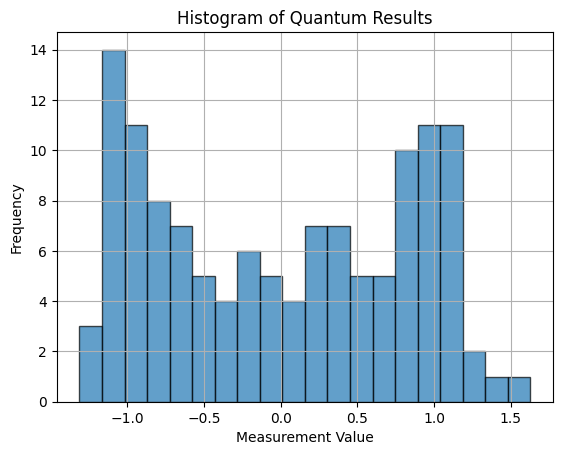

In [324]:
quantum_result =  job_result[0].data.evs
import matplotlib.pyplot as plt
import numpy as np

#e histogram
plt.hist(quantum_result, bins=20, edgecolor='black', alpha=0.7)
plt.title('Histogram of Quantum Results')
plt.xlabel('Measurement Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [319]:
print(f'Quantum result: min: {np.min(quantum_result)}, max: {np.max(quantum_result)}, mean: {np.mean(quantum_result)}, std: {np.std(quantum_result)}, shape: {quantum_result.shape}')

Quantum result: min: -1.312169312169312, max: 1.6282051282051282, mean: 0.009355857417975122, std: 0.8197414126847847, shape: (127,)


In [320]:
params_array = np.array(params)

In [321]:
params_array

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6])

In [323]:
print(f'params_array: min: {np.min(params_array)}, max: {np.max(params_array)}, mean: {np.mean(params_array)}, std: {np.std(params_array)}, shape: {params_array.shape}')

params_array: min: 0.0, max: 12.600000000000001, mean: 6.3, std: 3.6660605559646724, shape: (127,)
